# 5 支持向量机(SVM) Part II

支持向量机（SVM）是个非常强大并且有多种功能的机器学习模型，能够做线性或者非线性的分类，回归，甚至异常值检测。机器学习领域中最为流行的模型之一，是任何学习机器学习的人必备的工具。SVM 特别适合应用于复杂但中小规模数据集的分类问题。

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import warnings
warnings.filterwarnings("ignore")


## 5.3 非线性支持向量机分类

尽管线性 SVM 分类器在许多案例上表现得出乎意料的好，但是很多数据集并不是线性可分的。一种处理非线性数据集方法是增加更多的特征，例如多项式特征（正如你在第4章所做的那样）；在某些情况下可以变成线性可分的数据。在图 5-5的左图中，它只有一个特征`x1`的简单的数据集，正如你看到的，该数据集不是线性可分的。但是如果你增加了第二个特征$ x2=(x1)^2 $，产生的 2D 数据集就能很好的线性可分。

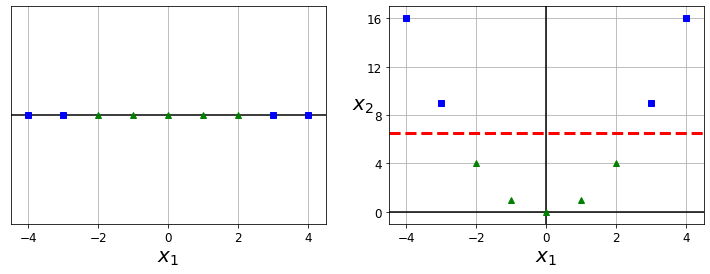

In [2]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=20)
plt.axis([-4.5, 4.5, -0.2, 0.2])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)

plt.show()

为了实施这个想法，通过 Scikit-Learn，你可以创建一个流水线（Pipeline）去包含多项式特征（PolynomialFeatures）变换（在 121 页的“Polynomial Regression”中讨论），然后一个`StandardScaler`和`LinearSVC`。让我们在卫星数据集（moons datasets）测试一下效果。

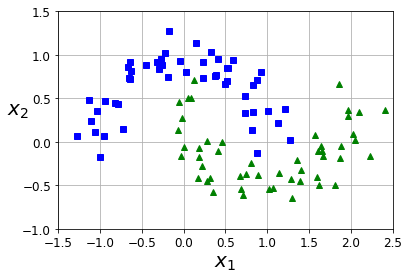

In [3]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [6]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

polynomial_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 LinearSVC(C=10, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=42, tol=0.0001,
                           verbose=0))],
         verbose=False)

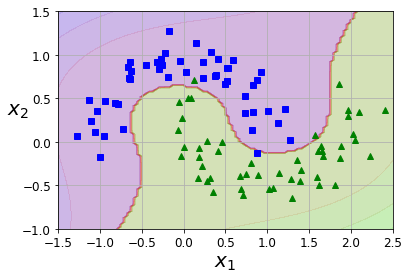

In [7]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

### 5.3.1 多项式核

添加多项式特征很容易实现，不仅仅在 SVM，在各种机器学习算法都有不错的表现，但是低次数的多项式不能处理非常复杂的数据集，而高次数的多项式却产生了大量的特征，会使模型变得慢。

幸运的是，当你使用 SVM 时，你可以运用一个被称为“核技巧”（kernel trick）的神奇数学技巧。它可以取得就像你添加了许多多项式，甚至有高次数的多项式，一样好的结果。所以不会大量特征导致的组合爆炸，因为你并没有增加任何特征。这个技巧可以用 SVC 类来实现。让我们在卫星数据集测试一下效果。

In [8]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=5, cache_size=200, class_weight=None, coef0=1,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='poly', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [9]:
poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])
poly100_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=5, cache_size=200, class_weight=None, coef0=100,
                     decision_function_shape='ovr', degree=10,
                     gamma='auto_deprecated', kernel='poly', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

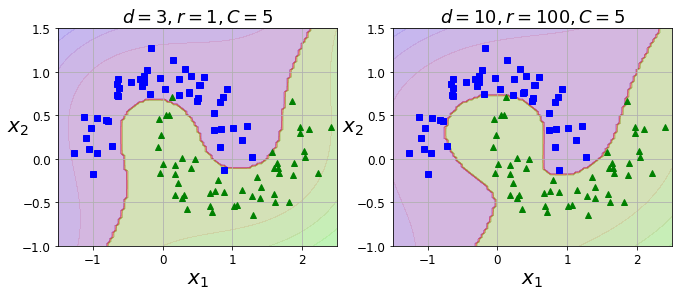

In [10]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.subplot(122)
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)

plt.show()

通用的方法是用网格搜索（grid search 见第 2 章）去找到最优超参数。首先进行非常粗略的网格搜索一般会很快，然后在找到的最佳值进行更细的网格搜索。对每个超参数的作用有一个很好的理解可以帮助你在正确的超参数空间找到合适的值。

### 5.3.2 增加相似特征

另一种解决非线性问题的方法是使用相似函数（similarity funtion）计算每个样本与特定地标（landmark）的相似度。例如，让我们来看看前面讨论过的一维数据集，并在`x1=-2`和`x1=1`之间增加两个地标（图 5-8 左图）。接下来，我们定义一个相似函数，即高斯径向基函数（Gaussian Radial Basis Function，RBF），设置`γ = 0.3`（见公式 5-1）

公式 5-1 RBF

$ \phi_{\gamma}(x, \ell) = exp(-\gamma \|x - \ell \|^2) $


它是个从 0 到 1 的钟型函数，值为 0 的离地标很远，值为 1 的在地标上。现在我们准备计算新特征。例如，我们看一下样本`x1=-1`：它距离第一个地标距离是 1，距离第二个地标是 2。因此它的新特征为$ x2=exp(-0.3 × (1^2))≈0.74 $ 和 $ x3=exp(-0.3 × (2^2))≈0.30 $ 。图 5-8 右边的图显示了特征转换后的数据集（删除了原始特征），正如你看到的，它现在是线性可分了。


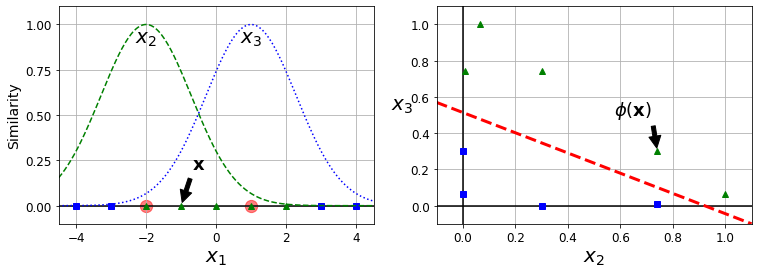

In [11]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

plt.show()

In [12]:
x1_example = X1D[3, 0]
for landmark in (-2, 1):
    k = gaussian_rbf(np.array([[x1_example]]), np.array([[landmark]]), gamma)
    print("Phi({}, {}) = {}".format(x1_example, landmark, k))

Phi(-1.0, -2) = [0.74081822]
Phi(-1.0, 1) = [0.30119421]


你可能想知道如何选择地标。最简单的方法是在数据集中的每一个样本的位置创建地标。这将产生更多的维度从而增加了转换后数据集是线性可分的可能性。但缺点是，`m`个样本，`n`个特征的训练集被转换成了`m`个实例，`m`个特征的训练集（假设你删除了原始特征）。这样一来，如果你的训练集非常大，你最终会得到同样大的特征。

### 5.3.3 高斯 RBF 核

就像多项式特征法一样，相似特征法对各种机器学习算法同样也有不错的表现。但是在所有额外特征上的计算成本可能很高，特别是在大规模的训练集上。然而，“核” 技巧再一次显现了它在 SVM 上的神奇之处：高斯核让你可以获得同样好的结果成为可能，就像你在相似特征法添加了许多相似特征一样，但事实上，你并不需要在RBF添加它们。我们使用 SVC 类的高斯 RBF 核来检验一下。

In [13]:
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])
rbf_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=5,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

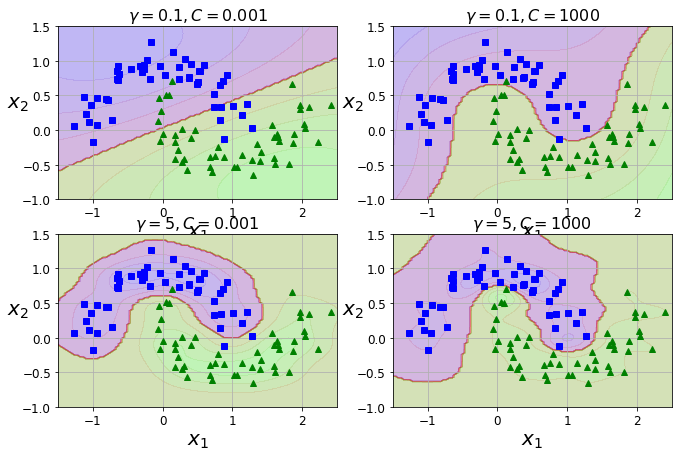

In [14]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

plt.figure(figsize=(11, 7))

for i, svm_clf in enumerate(svm_clfs):
    plt.subplot(221 + i)
    plot_predictions(svm_clf, [-1.5, 2.5, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)

plt.show()

还有其他的核函数，但很少使用。例如，一些核函数是专门用于特定的数据结构。在对文本文档或者 DNA 序列进行分类时，有时会使用字符串核（String kernels）（例如，使用 SSK 核（string subsequence kernel）或者基于编辑距离（Levenshtein distance）的核函数）。

> 提示
> 
> 这么多可供选择的核函数，你如何决定使用哪一个？一般来说，你应该先尝试线性核函数（记住`LinearSVC`比`SVC(kernel="linear")`要快得多），尤其是当训练集很大或者有大量的特征的情况下。如果训练集不太大，你也可以尝试高斯径向基核（Gaussian RBF Kernel），它在大多数情况下都很有效。如果你有空闲的时间和计算能力，你还可以使用交叉验证和网格搜索来试验其他的核函数，特别是有专门用于你的训练集数据结构的核函数。

## 5.4 SVM 回归

SVM 算法应用广泛：不仅仅支持线性和非线性的分类任务，还支持线性和非线性的回归任务。技巧在于逆转我们的目标：限制间隔违规的情况下，不是试图在两个类别之间找到尽可能大的“街道”（即间隔）。SVM 回归任务是限制间隔违规情况下，尽量放置更多的样本在“街道”上。“街道”的宽度由超参数`ϵ`控制。图 5-10 显示了在一些随机生成的线性数据上，两个线性 SVM 回归模型的训练情况。一个有较大的间隔（`ϵ=1.5`），另一个间隔较小（`ϵ=0.5`）。

In [15]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

In [16]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

LinearSVR(C=1.0, dual=True, epsilon=1.5, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=42, tol=0.0001, verbose=0)

In [17]:
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

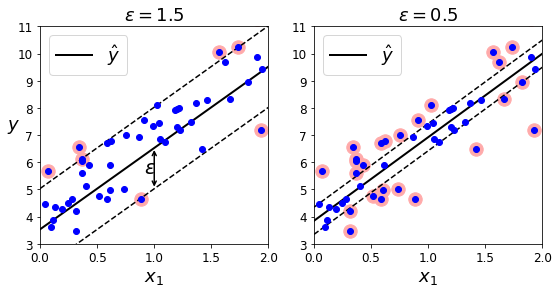

In [18]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

plt.figure(figsize=(9, 4))
plt.subplot(121)
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.subplot(122)
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)

plt.show()

添加更多的数据样本在间隔之内并不会影响模型的预测，因此，这个模型认为是不敏感的（ϵ-insensitive）。

你可以使用 Scikit-Learn 的`LinearSVR`类去实现线性 SVM 回归。下面的代码产生的模型左图（训练数据需要被中心化和标准化）

处理非线性回归任务，你可以使用核化的 SVM 模型。比如，下图显示了在随机二次方的训练集，使用二次方多项式核函数的 SVM 回归。左图是较小的正则化（即更大的`C`值），右图则是更大的正则化（即小的`C`值）

In [19]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

In [20]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(X, y)

SVR(C=100, cache_size=200, coef0=0.0, degree=2, epsilon=0.1,
    gamma='auto_deprecated', kernel='poly', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [21]:
from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1)
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

SVR(C=0.01, cache_size=200, coef0=0.0, degree=2, epsilon=0.1,
    gamma='auto_deprecated', kernel='poly', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

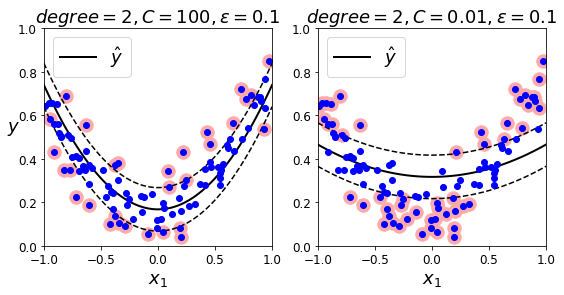

In [22]:
plt.figure(figsize=(9, 4))
plt.subplot(121)
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.subplot(122)
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)

plt.show()

下面的代码的模型在上图，其使用了 Scikit-Learn 的`SVR`类（支持核技巧）。在回归任务上，`SVR`类和`SVC`类是一样的，并且`LinearSVR`是和`LinearSVC`等价。`LinearSVR`类和训练集的大小成线性（就像`LinearSVC`类），当训练集变大，`SVR`会变的很慢（就像`SVC`类）

```py
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(X, y)
```

> 注
> 
> SVM 也可以用来做异常值检测，详情见 Scikit-Learn 文档
